In [14]:
import numpy as np
import gym
import gym.spaces as spaces
import gym.envs as envs
import time
import matplotlib.pyplot as plt

### Helper functions

In [15]:
# Policy Analysis

def get_score(env, policy, episodes=1000):
    wins = 0
    loses = 0
    total_reward = 0
    steps = []
    sequence = []
    min_steps = np.Inf
    
    for i in range(episodes):
        done = False
        state = env.reset()
        cnt = 0
        seq_actions = []
        while True:
            action = policy[state]
            seq_actions.append(action)

            s_prime, r, done, _ = env.step(action)
            
            total_reward += r
            cnt += 1
            state = s_prime
            
            if done and r == 1.0:
                wins += 1
                steps.append(cnt)
                if cnt < min_steps:
                    min_steps = cnt
                    sequence = seq_actions
                break;
            elif done and r == 0.0:
                loses += 1
                break;
    
    print("Won Percentage = ", (wins/episodes) * 100)
    print("Lost Percentage = ", (loses/episodes) * 100)
    print("Average steps taken to win = ", np.mean(steps))
    print("Average reward in all episodes = ", total_reward/episodes)
    
    return wins, loses, steps, sequence

In [66]:
def map_actions(optimal_policy):
    policy = []
    for i in optimal_policy:
        if i == 0: # LEFT
            policy.append('\u2190')
        elif i == 1: # DOWN
            policy.append('\u2193')
        elif i == 2: # RIGHT
            policy.append('\u2192')
        elif i == 3: # UP
            policy.append('\u2191')
    return policy

### Value Iteration
- Procedure Value_Iteration(S,A,P,R,θ):
           Inputs
                     S is the set of all states
                     A is the set of all actions
                     P is state transition function specifying P(s'|s,a)
                     R is a reward function R(s,a,s')
                     θ a threshold, θ>0
           Output
                     π[S] approximately optimal policy
                    V[S] value function
           Local
                     real array Vk[S] is a sequence of value functions
                     action array π[S]
           assign V0[S] arbitrarily
           k ←0
           repeat
                     k ←k+1
                     for each state s do
                               Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
           until ∀s |Vk[s]-Vk-1[s]| < θ
           for each state s do
                     π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
           return π,Vk

In [67]:
def get_action_values(env, s, V, gamma=0.99):
    action_values = np.zeros(env.nA)
    
    for a in range(env.nA):
        for prob, s_prime, r, _ in env.P[s][a]:
            action_values[a] += prob * ( r + gamma * V[s_prime])
            
    return action_values

In [68]:
'''Value Iteration'''
def value_iteration(env, gamma = 0.999, max_iteration = 1000):
    # Initialise Utility Function
    V = np.zeros(env.nS)

    for i in range(max_iteration):
        prev_V = np.copy(V)

        #loop over all states
        for s in range(env.nS):
            action_values = get_action_values(env, s, prev_V, gamma)
            best_action_value = np.max(action_values)
            V[s] = best_action_value

        if i % 5 == 0 and np.all(np.isclose(V, prev_V)):
            print("Value converged at iteration ", i)
            break

    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    for s in range(env.nS):
        s_action_value = get_action_values(env, s, V, gamma)
        optimal_policy[s] = np.argmax(s_action_value)

    return V, optimal_policy

### Test Value Iteration 

Number of states:  64
Number of actions:  4

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Value converged at iteration  595
Time to converge:  5.7e+02 ms
Optimal Value function: 
[[0.893 0.895 0.899 0.904 0.909 0.914 0.919 0.922]
 [0.892 0.894 0.897 0.902 0.906 0.912 0.917 0.925]
 [0.876 0.862 0.819 0.    0.778 0.865 0.909 0.931]
 [0.864 0.811 0.699 0.42  0.564 0.    0.881 0.939]
 [0.853 0.711 0.469 0.    0.494 0.568 0.799 0.95 ]
 [0.846 0.    0.    0.153 0.353 0.413 0.    0.964]
 [0.841 0.    0.164 0.105 0.    0.319 0.    0.981]
 [0.838 0.612 0.387 0.    0.272 0.544 0.772 0.   ]]
Final Policy: 
[['↑' '→' '→' '→' '→' '→' '→' '→']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '→']
 ['←' '↑' '←' '←' '→' '↑' '→' '→']
 ['←' '←' '←' '↓' '←' '←' '→' '→']
 ['←' '↑' '←' '←' '→' '↓' '↑' '→']
 ['←' '←' '←' '↓' '↑' '←' '←' '→']
 ['←' '←' '↓' '←' '←' '←' '←' '→']
 ['←' '↓' '←' '←' '↓' '→' '↓' '←']]


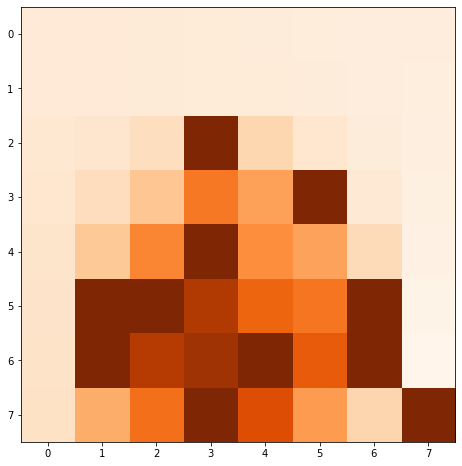

In [69]:
env = gym.make('FrozenLake8x8-v0')
print("Number of states: ", env.nS)
print("Number of actions: ", env.nA)

env.render()

start_time = time.time()
optimal_value, optimal_policy = value_iteration(env.env, gamma=0.999, max_iteration=1000 )
stop_time = time.time()
time_taken = (stop_time - start_time)*1000

print (f"Time to converge: {time_taken : 0.3} ms")

print('Optimal Value function: ')
print(np.round(optimal_value, 3).reshape((8, 8)))

plt.figure(figsize=(8,8))
plt.imshow(optimal_value.reshape((8, 8)), cmap='Oranges_r')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy).reshape((8,8)))

In [71]:
wins, loses, steps, sequence = get_score(env, optimal_policy, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence))
print("Min steps to win: ", len(sequence))

Won Percentage =  88.1
Lost Percentage =  11.899999999999999
Average steps taken to win =  98.07150964812713
Average reward in all episodes =  0.881
Sequence of min steps taken:  ['↑', '→', '→', '→', '→', '↑', '↑', '↑', '↑', '→', '→', '↑', '→', '↑', '→', '→', '→', '→', '→', '→', '→']
Min steps to win:  21


### Policy Iteration
The policy iteration algorithm manipulates the policy directly, rather than finding it indirectly via the optimal value function. It operates as follows:

<img src='http://incompleteideas.net/book/first/ebook/pseudotmp1.png'>
<img src='http://incompleteideas.net/book/first/ebook/imgtmp35.png'>

In [72]:
def get_policy_val(env, policy, V, gamma):
    policy_values = np.zeros(env.nS)
    for s, a in zip(range(len(policy)), policy):
        for prob, s_prime, r, _ in env.P[s][a]:
            policy_values[s] += prob * ( r + gamma * V[s_prime])
            
    return policy_values

In [73]:
def policy_iteration(env, gamma = 0.99, max_iteration = 1000):
    V = np.zeros(env.nS)
    
    P = np.random.randint(0, 4, env.nS)
    prev_P = np.copy(P)
    
    for i in range(max_iteration):
        
        V = get_policy_val(env, P, V, gamma)
        
        for s in range(env.nS):
            s_action_value = get_action_values(env, s, V, gamma)
            P[s] = np.argmax(s_action_value)
        
        if i % 10 == 0:
            if np.all(np.equal(P, prev_P)):
                print("Policy converged at iteration ", i)
                break
            prev_P = np.copy(P)
        
    return V, P

### Testing Policy Iteration

Number of states:  64
Number of actions:  4

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Policy converged at iteration  70
Time to converge:  79.2 ms
Optimal Value function: 
[[0.409 0.435 0.472 0.513 0.553 0.59  0.613 0.62 ]
 [0.402 0.422 0.455 0.494 0.537 0.585 0.625 0.638]
 [0.379 0.382 0.37  0.    0.468 0.559 0.641 0.668]
 [0.343 0.332 0.295 0.203 0.325 0.    0.646 0.711]
 [0.291 0.261 0.181 0.    0.317 0.403 0.602 0.768]
 [0.224 0.    0.    0.09  0.233 0.299 0.    0.837]
 [0.181 0.    0.034 0.041 0.    0.268 0.    0.916]
 [0.159 0.104 0.064 0.    0.254 0.509 0.754 0.   ]]
Final Policy: 
[['↑' '→' '→' '→' '→' '→' '→' '→']
 ['↑' '↑' '↑' '↑' '↑' '→' '→' '↓']
 ['↑' '↑' '←' '←' '→' '↑' '→' '↓']
 ['↑' '↑' '↑' '↓' '←' '←' '→' '→']
 ['↑' '↑' '←' '←' '→' '↓' '↑' '→']
 ['←' '←' '←' '↓' '↑' '←' '←' '→']
 ['←' '←' '↓' '←' '←' '←' '←' '→']
 ['←' '↓' '←' '←' '↓' '→' '↓' '←']]


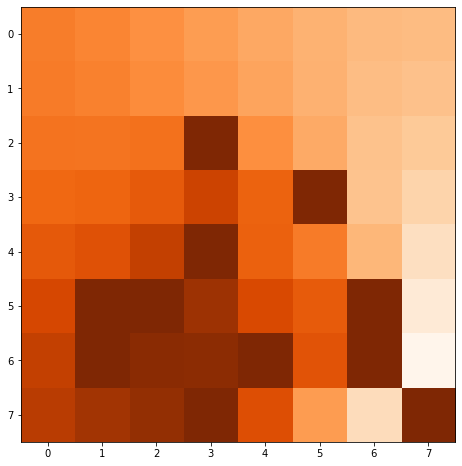

In [74]:
env2 = gym.make('FrozenLake8x8-v0')
print("Number of states: ", env2.nS)
print("Number of actions: ", env2.nA)

env2.render()

start_time2 = time.time()
optimal_value2, optimal_policy2 = policy_iteration(env2.env, gamma=0.999, max_iteration=1000)
stop_time2 = time.time()
time_taken2 = (stop_time2 - start_time2) * 1000

print (f"Time to converge: {time_taken2 : 0.3} ms")

print('Optimal Value function: ')
print(np.round(optimal_value2, 3).reshape((8, 8)))
plt.figure(figsize=(8,8))
plt.imshow(optimal_value2.reshape((8, 8)), cmap='Oranges_r')

print('Final Policy: ')
policy2 = map_actions(optimal_policy2)

print(np.array(policy2).reshape((8,8)))

In [76]:
wins2, loses2, steps2, sequence2 = get_score(env2, optimal_policy2, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence2))
print("Min steps to win: ", len(sequence2))

Won Percentage =  85.8
Lost Percentage =  14.2
Average steps taken to win =  83.35664335664336
Average reward in all episodes =  0.858
Sequence of min steps taken:  ['↑', '↑', '→', '→', '→', '↑', '↑', '↑', '→', '↑', '→', '→', '↑', '→', '→', '→', '→', '→', '→', '→']
Min steps to win:  20


In [77]:
(optimal_policy - optimal_policy2).reshape((8,8))

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  1],
       [-3,  0,  0,  0,  0,  0,  0,  1],
       [-3, -3, -3,  0,  0,  0,  0,  0],
       [-3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

## Q- Learning

In [78]:
import random
env3 = gym.make('FrozenLake8x8-v0')
action_size = env3.action_space.n
state_size = env3.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 100000        # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.0001

In [79]:
# List of rewards
rewards = []

start_time = time.time()

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env3.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env3.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env3.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

stop_time = time.time()

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print("Time taken = ", (stop_time - start_time), " s.")
print(qtable)

Score over time: 0.19433
Time taken =  133.72452592849731  s.
[[7.91717559e-03 2.34324691e-02 8.03674444e-03 7.86281715e-03]
 [9.06851192e-03 8.81200675e-03 1.62411374e-02 8.60271843e-03]
 [1.08637520e-02 1.31208155e-02 2.68929311e-02 1.06615104e-02]
 [3.41960677e-02 2.54091721e-02 1.68848051e-02 1.79127239e-02]
 [2.44756361e-02 2.73740152e-02 3.02835544e-02 4.06613199e-02]
 [2.74598249e-02 2.90626773e-02 4.86748408e-02 6.09468835e-02]
 [3.73733135e-02 6.42821678e-02 7.37696069e-02 3.85897182e-02]
 [3.83078563e-02 9.94297087e-02 5.20222425e-02 2.61381759e-02]
 [8.06037314e-03 6.98438959e-03 7.89687648e-03 1.69285323e-02]
 [4.72356877e-03 7.27395264e-03 8.36451380e-03 1.42152846e-02]
 [1.29423827e-02 9.83452446e-03 1.16337931e-02 2.22245885e-02]
 [7.57941108e-03 6.51311955e-04 5.89301053e-03 3.86352416e-02]
 [1.06298858e-02 6.88333509e-03 5.72484916e-02 2.65650875e-02]
 [1.56645192e-02 1.42817657e-02 2.82321778e-02 1.30092696e-01]
 [3.79073119e-02 5.99373863e-02 9.87537242e-02 2.8806750

Optimal Value function: 
[[0.023 0.016 0.027 0.034 0.041 0.061 0.074 0.099]
 [0.017 0.014 0.022 0.039 0.057 0.13  0.099 0.132]
 [0.007 0.007 0.002 0.    0.032 0.072 0.241 0.15 ]
 [0.005 0.004 0.    0.006 0.054 0.    0.099 0.221]
 [0.003 0.001 0.    0.    0.01  0.038 0.421 0.483]
 [0.005 0.    0.    0.    0.004 0.251 0.    0.681]
 [0.001 0.    0.    0.    0.    0.576 0.    0.955]
 [0.001 0.001 0.    0.    0.086 0.858 0.983 0.   ]]
Final Policy: 
[['↓' '→' '→' '←' '↑' '↑' '→' '↓']
 ['↑' '↑' '↑' '↑' '→' '↑' '→' '→']
 ['→' '→' '←' '←' '→' '↑' '→' '←']
 ['↑' '↑' '→' '↓' '←' '←' '→' '↓']
 ['↑' '↑' '←' '←' '→' '↓' '↑' '→']
 ['←' '←' '←' '→' '↓' '←' '←' '→']
 ['←' '←' '→' '↑' '←' '→' '←' '→']
 ['←' '↓' '←' '←' '→' '→' '↓' '←']]


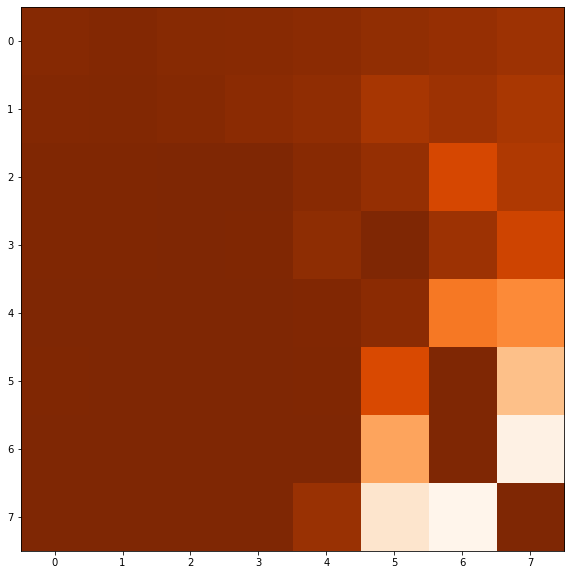

In [80]:
optimal_policy3 = np.argmax(qtable, axis=1)
optimal_value3 = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value3, 3).reshape((8, 8)))
plt.figure(figsize=(10,10))
plt.imshow(optimal_value3.reshape((8, 8)), cmap='Oranges_r')

print('Final Policy: ')
policy3 = map_actions(optimal_policy3)

print(np.array(policy3).reshape((8,8)))

In [81]:
wins3, loses3, steps3, sequence3 = get_score(env3, optimal_policy3, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence3))
print("Min steps to win: ", len(sequence3))

Won Percentage =  59.099999999999994
Lost Percentage =  40.9
Average steps taken to win =  98.6429780033841
Average reward in all episodes =  0.591
Sequence of min steps taken:  ['↓', '↓', '→', '→', '→', '→', '→', '↑', '↑', '→', '→', '←', '→', '↓', '↑', '→', '→', '→', '→']
Min steps to win:  19


In [75]:
import pandas as pd
pd.DataFrame(np.round(optimal_value2, 3).reshape((8,8))).to_csv('a.csv')